# HALO-AC3

This example demonstrated the use of ac3airborne for HALO flights during HALO-AC3.

For the instalaltion of required modules, see: https://speicherwolke.uni-leipzig.de/index.php/s/cgzrgH5nX3dxAso

If you run into problems with the code or just want to share your plots, feel free to join the ac3airborne channel on slack!

In [1]:
import ac3airborne
from ac3airborne.tools import flightphase
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import matplotlib.dates as mdates
from matplotlib import cm
import ipyleaflet
from ipyleaflet import Polyline, Map, basemaps, basemap_to_tiles
from ipywidgets import Layout
from simplification.cutil import simplify_coords_idx
%matplotlib inline

To access the data from the cloud server easily, the credentials can saved in an environment variable of your computer (or typed in directly here).

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

kwds = {'simplecache': dict(
    cache_storage=os.environ['INTAKE_CACHE'], 
    same_names=True
)}

## Select a flight
To select a flight, specify the mission, platform and flight number in the flight_id.

In [3]:
mission = 'HALO-AC3'
platform = 'HALO'
flight_id = 'HALO-AC3_HALO_RF03'

## Load intake catalog and flight segments
The first HALO flights are already divided into logical segments. We can check the meta data of the selected flight here.

In [4]:
# load intake catalog and flight segments
cat = ac3airborne.get_intake_catalog()
meta = ac3airborne.get_flight_segments()

In [6]:
flight = meta[mission][platform][flight_id]

In [7]:
list(flight)

['co-location',
 'contacts',
 'date',
 'events',
 'flight_id',
 'flight_report',
 'landing',
 'mission',
 'name',
 'platform',
 'remarks',
 'segments',
 'takeoff']

## Read data of flight
Several datasets are already available on the cloud. Here we present an example for the HAMP data as well as the basic gps information.

In [8]:
# get list of available datasets
list(cat[mission][platform])

['BAHAMAS',
 'BACARDI',
 'DROPSONDES',
 'DROPSONDES_GRIDDED',
 'GPS_INS',
 'HAMP_RADIOMETER',
 'HAMP_RADAR',
 'KT19',
 'SMART',
 'AMSR2_SIC']

When we use caching, we do not need to download the data every time we call the script.

In [26]:
# read hamp data
ds_hamp_radiometer = cat[mission][platform]['HAMP_RADIOMETER'][flight_id](storage_options=kwds).to_dask()
ds_hamp_radar = cat[mission][platform]['HAMP_RADAR'][flight_id](storage_options=kwds).to_dask()

# read gps
ds_gps_ins = cat[mission][platform]['GPS_INS'][flight_id](storage_options=kwds).to_dask()

/net/sever/mech/miniconda3/envs/howtoac3/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/net/sever/mech/miniconda3/envs/howtoac3/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/net/sever/mech/miniconda3/envs/howtoac3/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.

## Plot flight on map
This map provides an overview of the flight using VIS satellite imagery and labels for every segment. The code is simply copied from here: https://igmk.github.io/how_to_ac3airborne/flight_segmentation.html

In [27]:
def colors(n):
    """Creates set of random colors of length n"""
    
    cmap = cm.get_cmap('gist_rainbow')
    rnd = np.random.uniform(low=0, high=1, size=n)
    cols = cmap(rnd)
    
    return cols


def simplify_dataset(ds, tolerance):
    indices_to_take = simplify_coords_idx(np.stack([ds.lat.values, ds.lon.values], axis=1), tolerance)
    return ds.isel(time=indices_to_take)

In the map below you can switch on and off every segment. The segment names are shown in the small legend.

In [28]:
# plot map
m = Map(basemap=basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, str(flight['date'])),
        center=(80, 10),
        zoom=4,
        scroll_wheel_zoom=True,
        layout=Layout(width='1000px', height='1000px')
        )

col_segments = colors(len(flight['segments']))

for i, segment in enumerate(flight['segments']):
    
    # reduce flight segment
    ds_reduced = simplify_dataset(ds_gps_ins.sel(time=slice(segment['start'], 
                                                            segment['end'])), 
                                  1e-5)
    
    # plot flight segment
    line = Polyline(locations=np.stack([ds_reduced.lat.values, ds_reduced.lon.values], axis=1).tolist(),
                    color=to_hex(col_segments[i]),
                    fill=False,
                    weight=2,
                    name=str(i) + ': ' + segment['name'])
    m.add_layer(line)

m.add_control(ipyleaflet.ScaleControl())
m.add_control(ipyleaflet.LayersControl(position='topright'))
m.add_control(ipyleaflet.FullScreenControl())

display(m)

/tmp/ipykernel_1192068/4205725992.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('gist_rainbow')


Map(center=[80, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

## View data along a specific transect
Using the start and end times for each segment, we can look at data specifically in certain regions. For example at the southward leg "high level 9".

In [29]:
# list all segments
for segment in flight['segments']:
    print(segment['name'])

major ascent
high level 1
long turn
high level 2
long turn
small ascent 1
high level 3
long turn
high level 4
long turn
high level 5
long turn
high level 6
long turn
high level 7
long turn
high level 8
long turn
high level 9
short turn
high level 10
major descent


In [30]:
flight_query = flightphase.FlightPhaseFile(flight)

In [31]:
attribute = 'name'
value = 'high level 9'

queried = flight_query.select(attribute, value) 
queried

[{'dropsondes': ['HALO-AC3_HALO_RF03_DS12',
   'HALO-AC3_HALO_RF03_DS13',
   'HALO-AC3_HALO_RF03_DS14',
   'HALO-AC3_HALO_RF03_DS15',
   'HALO-AC3_HALO_RF03_DS16'],
  'end': datetime.datetime(2022, 3, 13, 15, 30, 43),
  'irregularities': [],
  'kinds': ['high_level'],
  'levels': [40800],
  'name': 'high level 9',
  'segment_id': 'HALO-AC3_HALO_RF03_hl09',
  'start': datetime.datetime(2022, 3, 13, 13, 43, 1)}]

In [32]:
segment = queried[0]

In [33]:
t = dict(time=slice(segment['start'], segment['end']))

/tmp/ipykernel_1192068/2367074114.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', 7).colors
/tmp/ipykernel_1192068/2367074114.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', 5).colors
/tmp/ipykernel_1192068/2367074114.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', 6).colors


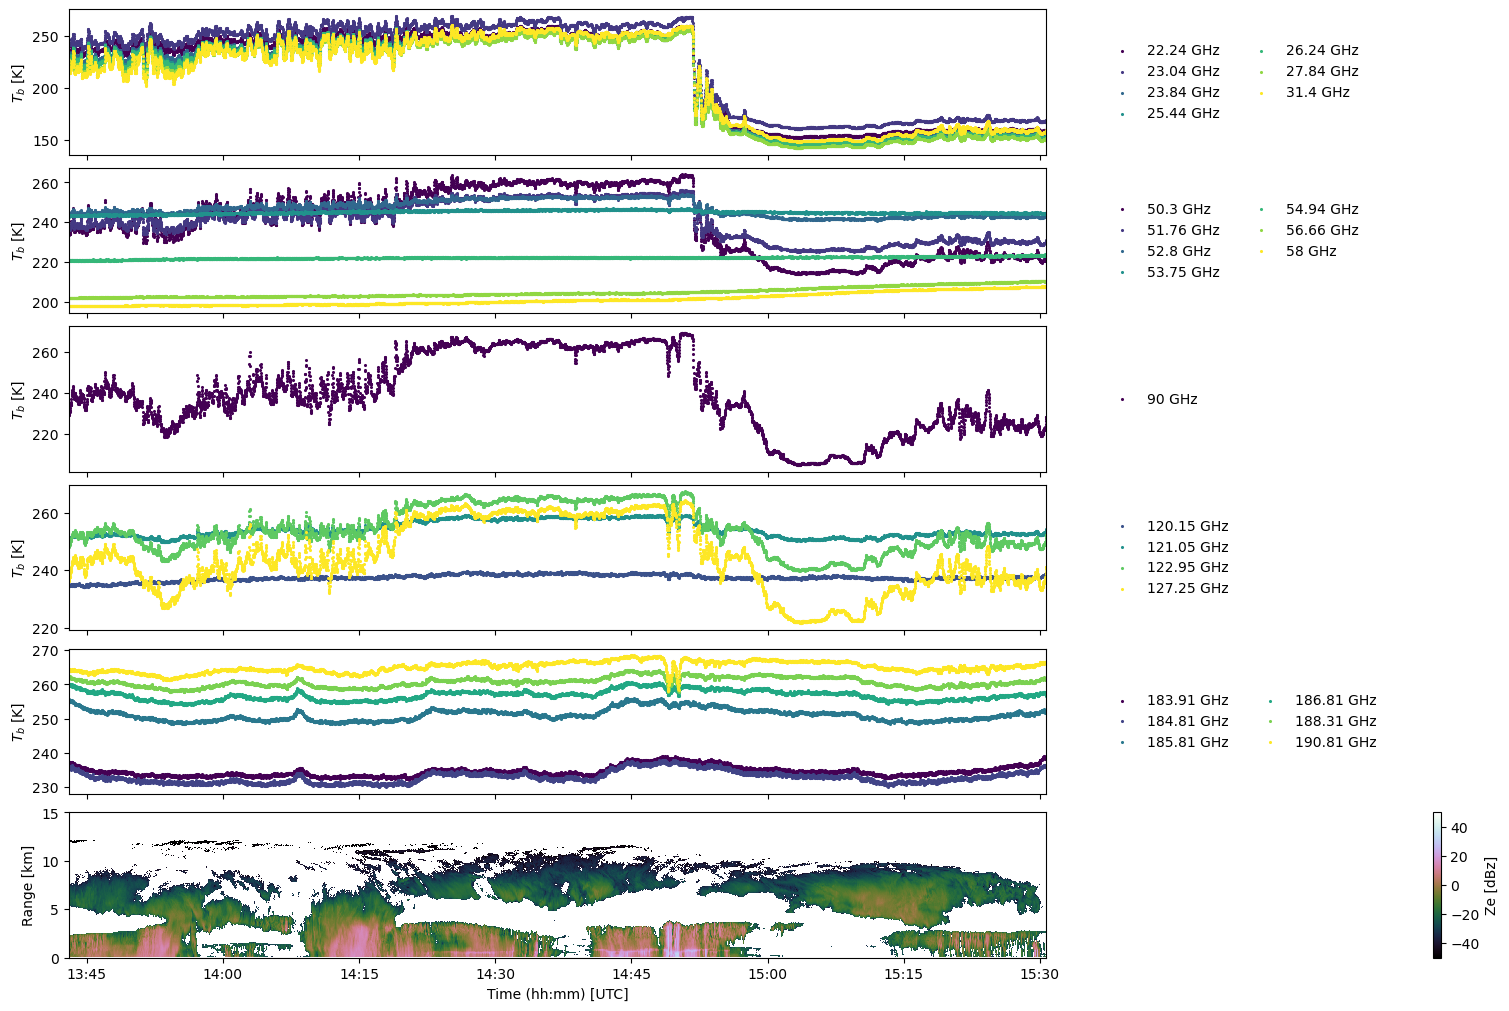

In [34]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True, gridspec_kw=dict(height_ratios=(1, 1, 1, 1, 1, 1)), constrained_layout=True, figsize=(15, 10))

kwargs = dict(s=5, linewidths=0)
colors = cm.get_cmap('viridis', 7).colors
for i in range(0, 7):
    ax1.scatter(ds_hamp_radiometer.time.sel(**t), ds_hamp_radiometer.TB.sel(uniRadiometer_freq=ds_hamp_radiometer.freq[i], **t), 
                label='%g GHz'%ds_hamp_radiometer.freq[i], color=colors[i], **kwargs)

for i in range(7, 14):
    ax2.scatter(ds_hamp_radiometer.time.sel(**t), ds_hamp_radiometer.TB.sel(uniRadiometer_freq=ds_hamp_radiometer.freq[i], **t), 
                label='%g GHz'%ds_hamp_radiometer.freq[i], color=colors[i-7], **kwargs)

ax1.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)
ax2.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)

ax1.set_ylabel('$T_b$ [K]')
ax2.set_ylabel('$T_b$ [K]')

colors = cm.get_cmap('viridis', 5).colors
for i in range(14, 15):
    ax3.scatter(ds_hamp_radiometer.time.sel(**t), ds_hamp_radiometer.TB.sel(uniRadiometer_freq=ds_hamp_radiometer.freq[i], **t), label='%g GHz'%ds_hamp_radiometer.freq[i], color=colors[i-14], **kwargs)

for i in range(15, 19):
    ax4.scatter(ds_hamp_radiometer.time.sel(**t), ds_hamp_radiometer.TB.sel(uniRadiometer_freq=ds_hamp_radiometer.freq[i], **t), label='%g GHz'%ds_hamp_radiometer.freq[i], color=colors[i-14], **kwargs)

ax3.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax4.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left')
    
ax3.set_ylabel('$T_b$ [K]')
ax4.set_ylabel('$T_b$ [K]')

colors = cm.get_cmap('viridis', 6).colors
for i in range(19, 25):
    ax5.scatter(ds_hamp_radiometer.time.sel(**t), ds_hamp_radiometer.TB.sel(uniRadiometer_freq=ds_hamp_radiometer.freq[i], **t), label='%g GHz'%ds_hamp_radiometer.freq[i], color=colors[i-19], **kwargs)

ax5.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)

ax5.set_ylabel('$T_b$ [K]')

im = ax6.pcolormesh(ds_hamp_radar.time.sel(**t), ds_hamp_radar.height*1.e-3, ds_hamp_radar.dBZg.sel(**t).T, vmin=-50, vmax=50, cmap='cubehelix', shading='nearest')
ax6.set_xlim(segment['start'], segment['end'])
ax6.set_ylim([0, 15])
ax6.set_ylabel('Range [km]')
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax6.set_xlabel('Time (hh:mm) [UTC]')

fig.colorbar(im, ax=ax6, label='Ze [dBz]')

plt.show()